In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [2]:
config = f"""
execution:
    exp_id: exp_005
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

## 特徴生成

In [3]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())
    columns += gb.columns.tolist()

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)
    columns += f_names

    # rolling
    dts = [-1000, -100, -50, -10, 10, 50, 100, 1000]
    for dt in dts:            
        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(np.arange(len(train)) // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [4]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [06:32<00:00,  1.42s/it]


## 学習

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
train.head(5)

,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,enmo_rolling_square_mean_50,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id,fold
0,0.006461,0.043200,NaN,NaN,NaN,0.007771,NaN,NaN,NaN,0.000428,...,NaN,0.000000,NaN,NaN,NaN,40557.5,1,11.5,af91d9a50547,2
1,0.000117,0.000833,NaN,NaN,0.047400,0.000192,NaN,NaN,0.002144,0.000004,...,0.000000,0.000000,NaN,NaN,0.000000,40677.5,1,35.5,af91d9a50547,2
2,0.000767,0.005475,0.5969,NaN,0.457854,0.001198,0.022684,NaN,0.024919,0.000319,...,0.000003,0.000000,0.00146,NaN,0.001634,40797.5,1,59.5,af91d9a50547,2
3,0.083833,0.347392,0.5969,NaN,0.596900,0.083032,0.025412,NaN,0.042692,0.036481,...,0.000004,0.001924,0.00146,NaN,0.002064,40917.5,1,83.5,af91d9a50547,2
4,0.014787,0.048846,0.5969,NaN,0.309038,0.012615,0.028460,NaN,0.028898,0.001910,...,0.000001,0.000000,0.00146,NaN,0.000604,41037.5,1,107.5,af91d9a50547,2


In [6]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.61235
[50]	eval-logloss:0.10516
[100]	eval-logloss:0.10000
[150]	eval-logloss:0.09943
[200]	eval-logloss:0.09929
[225]	eval-logloss:0.09963


 20%|██        | 1/5 [11:21<45:24, 681.22s/it]

== fold 1 ==
[0]	eval-logloss:0.61083
[50]	eval-logloss:0.08674
[100]	eval-logloss:0.07990
[150]	eval-logloss:0.07869
[200]	eval-logloss:0.07790
[250]	eval-logloss:0.07754
[300]	eval-logloss:0.07732
[350]	eval-logloss:0.07733
[387]	eval-logloss:0.07741


 40%|████      | 2/5 [30:54<48:31, 970.44s/it]

== fold 2 ==
[0]	eval-logloss:0.61058
[50]	eval-logloss:0.09562
[100]	eval-logloss:0.09286
[134]	eval-logloss:0.09311


 60%|██████    | 3/5 [38:15<24:17, 728.66s/it]

== fold 3 ==
[0]	eval-logloss:0.61138
[50]	eval-logloss:0.10055
[100]	eval-logloss:0.09871
[125]	eval-logloss:0.09936


 80%|████████  | 4/5 [44:58<10:00, 600.08s/it]

== fold 4 ==
[0]	eval-logloss:0.61228
[50]	eval-logloss:0.10225
[100]	eval-logloss:0.09453
[150]	eval-logloss:0.09286
[200]	eval-logloss:0.09206
[250]	eval-logloss:0.09155
[300]	eval-logloss:0.09141
[350]	eval-logloss:0.09136
[400]	eval-logloss:0.09141
[428]	eval-logloss:0.09151


100%|██████████| 5/5 [1:06:43<00:00, 800.68s/it]


In [7]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
train

,target,step,series_id,fold,oof
0,1,11.5,038441c925bb,2,0.998872
1,1,35.5,038441c925bb,2,0.998753
2,1,59.5,038441c925bb,2,0.991332
3,1,83.5,038441c925bb,2,0.990948
4,1,107.5,038441c925bb,2,0.990733
...,...,...,...,...,...
5331158,1,592283.5,fe90110788d2,2,0.909594
5331159,1,592307.5,fe90110788d2,2,0.887354
5331160,1,592331.5,fe90110788d2,2,0.965776
5331161,1,592355.5,fe90110788d2,2,0.995170


## 予測値の作成

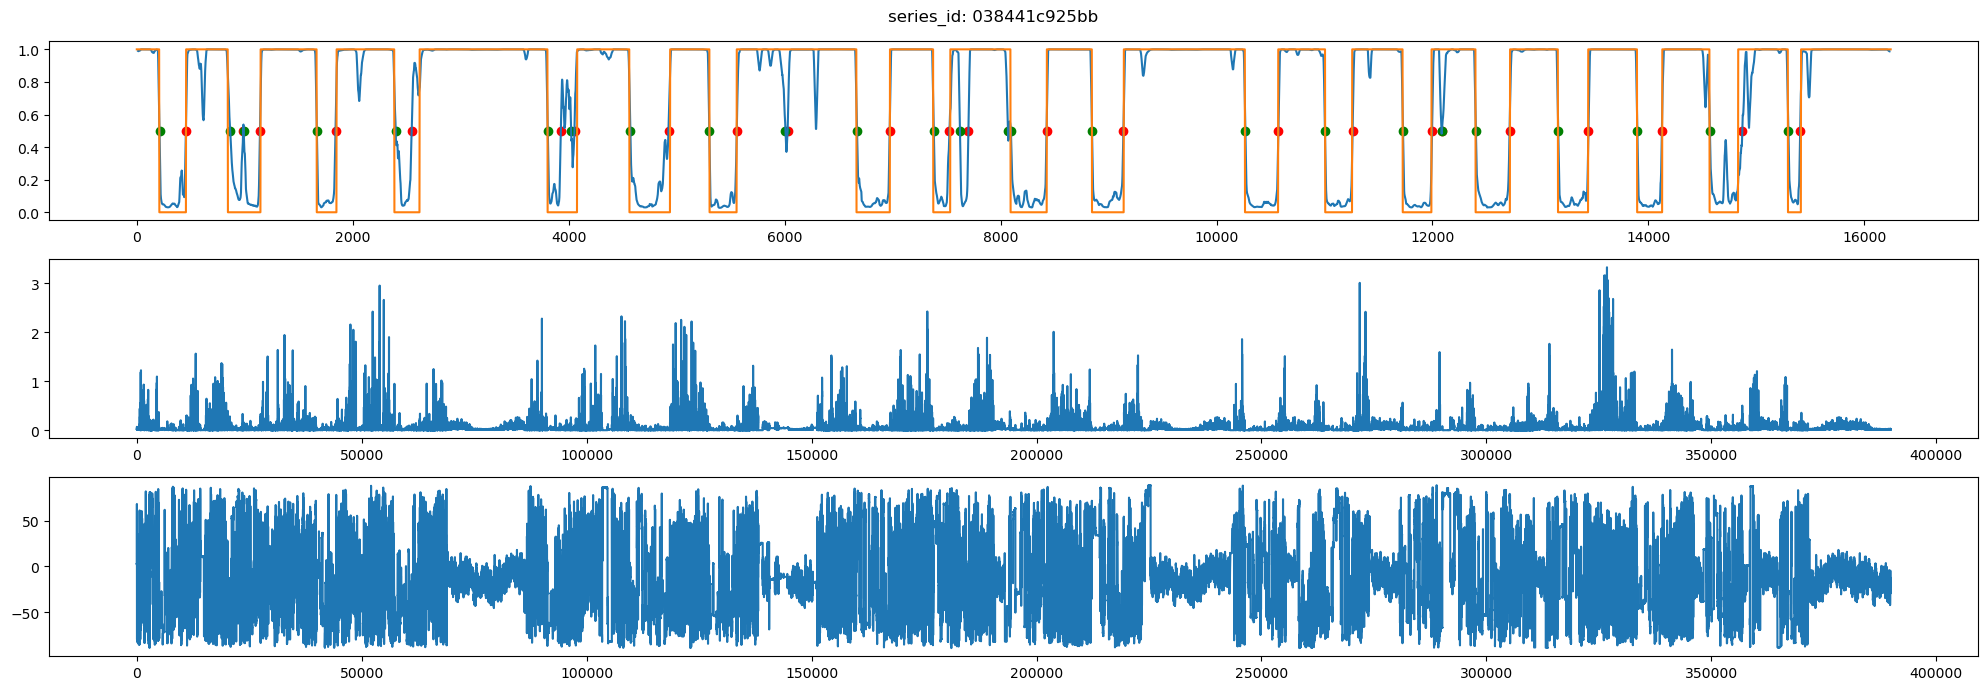

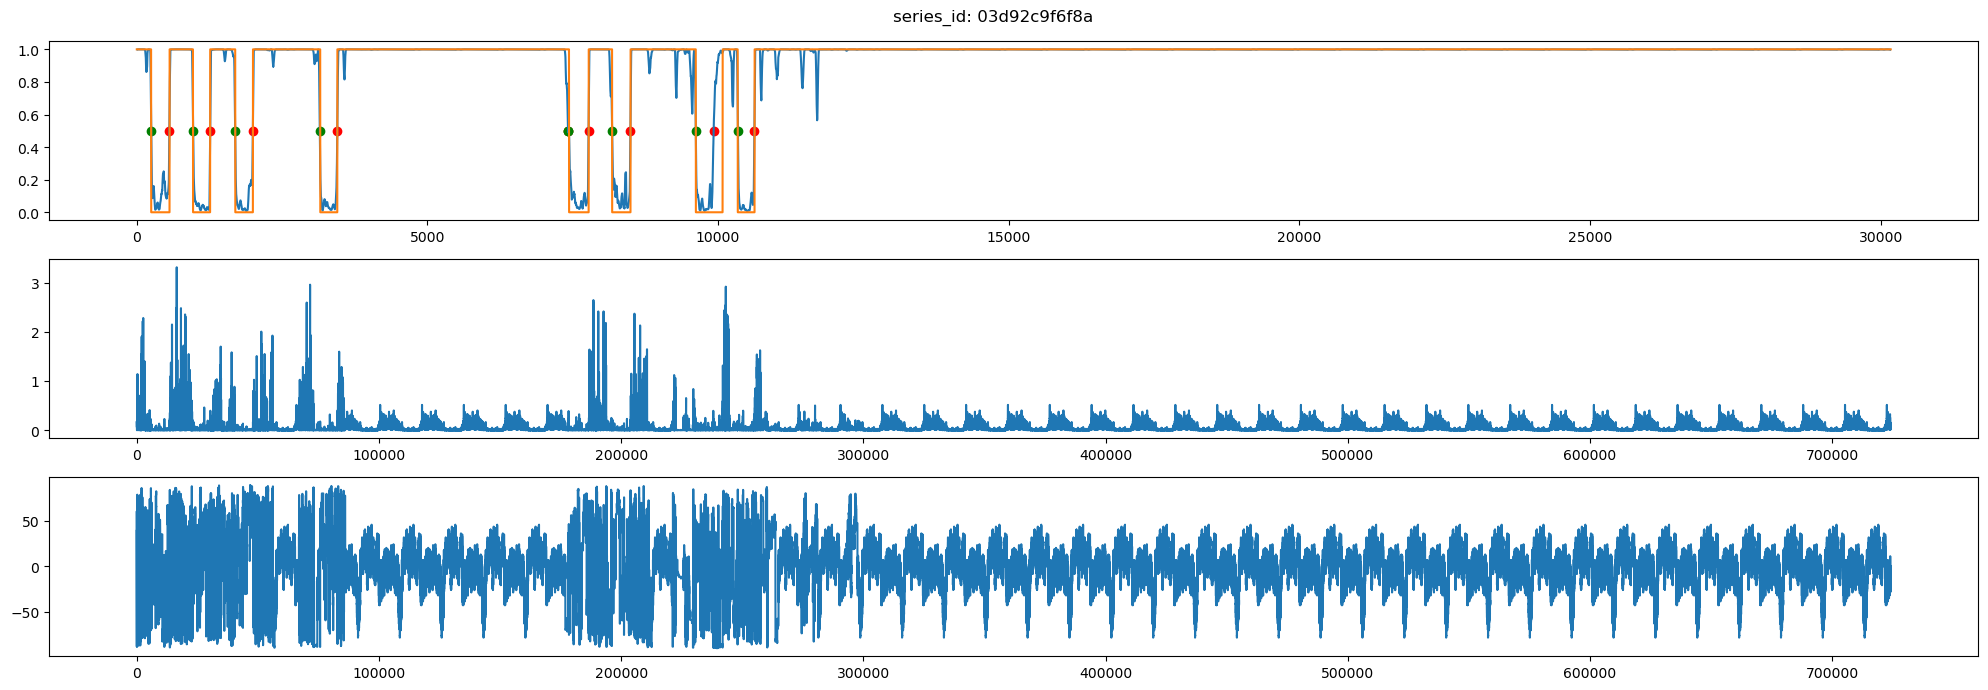

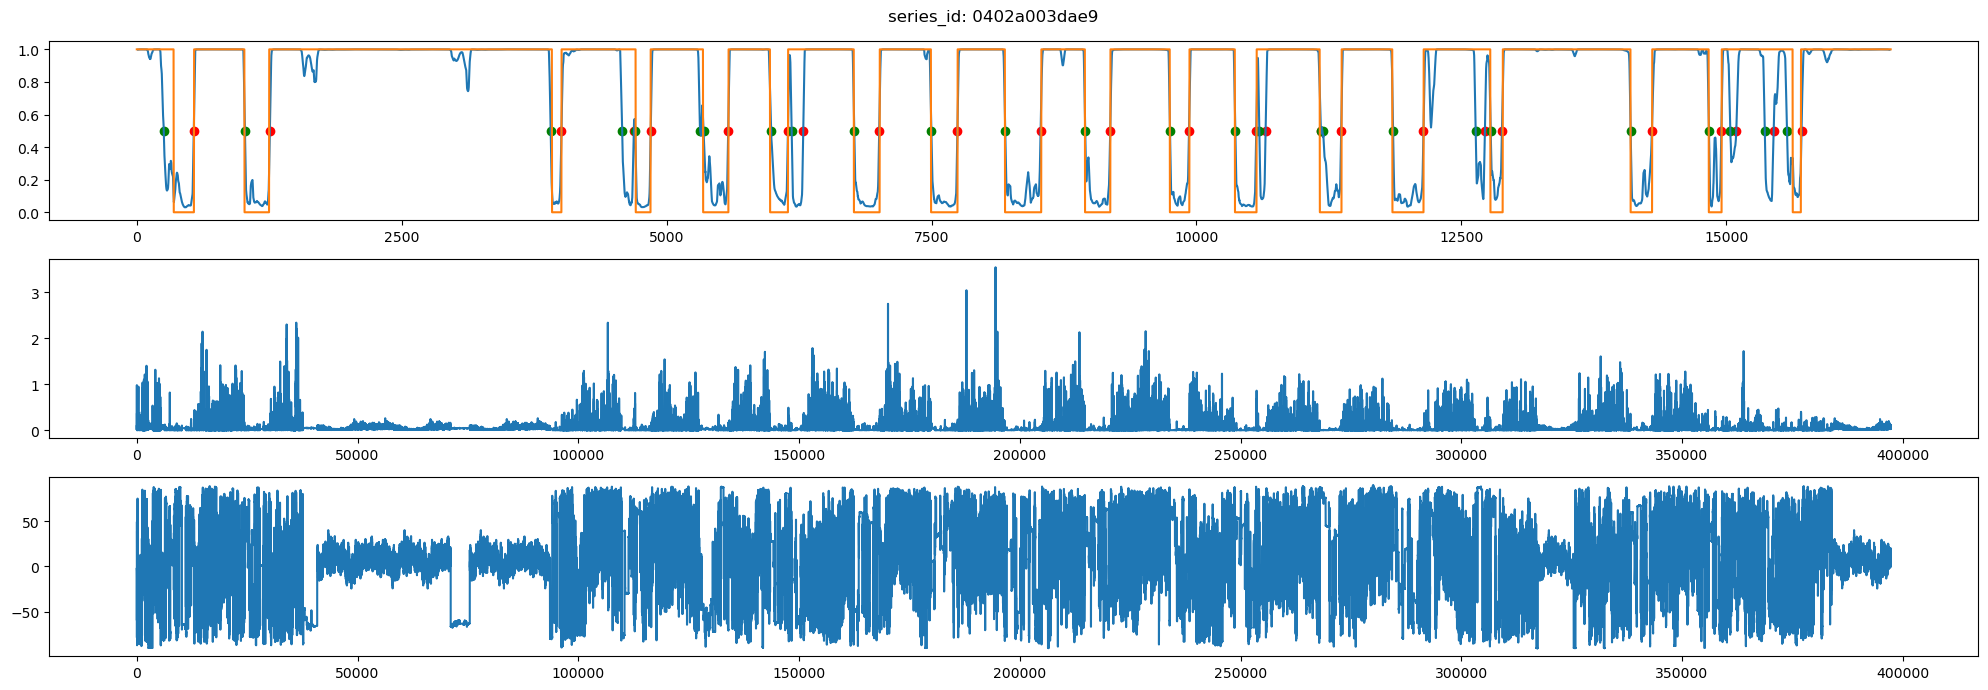

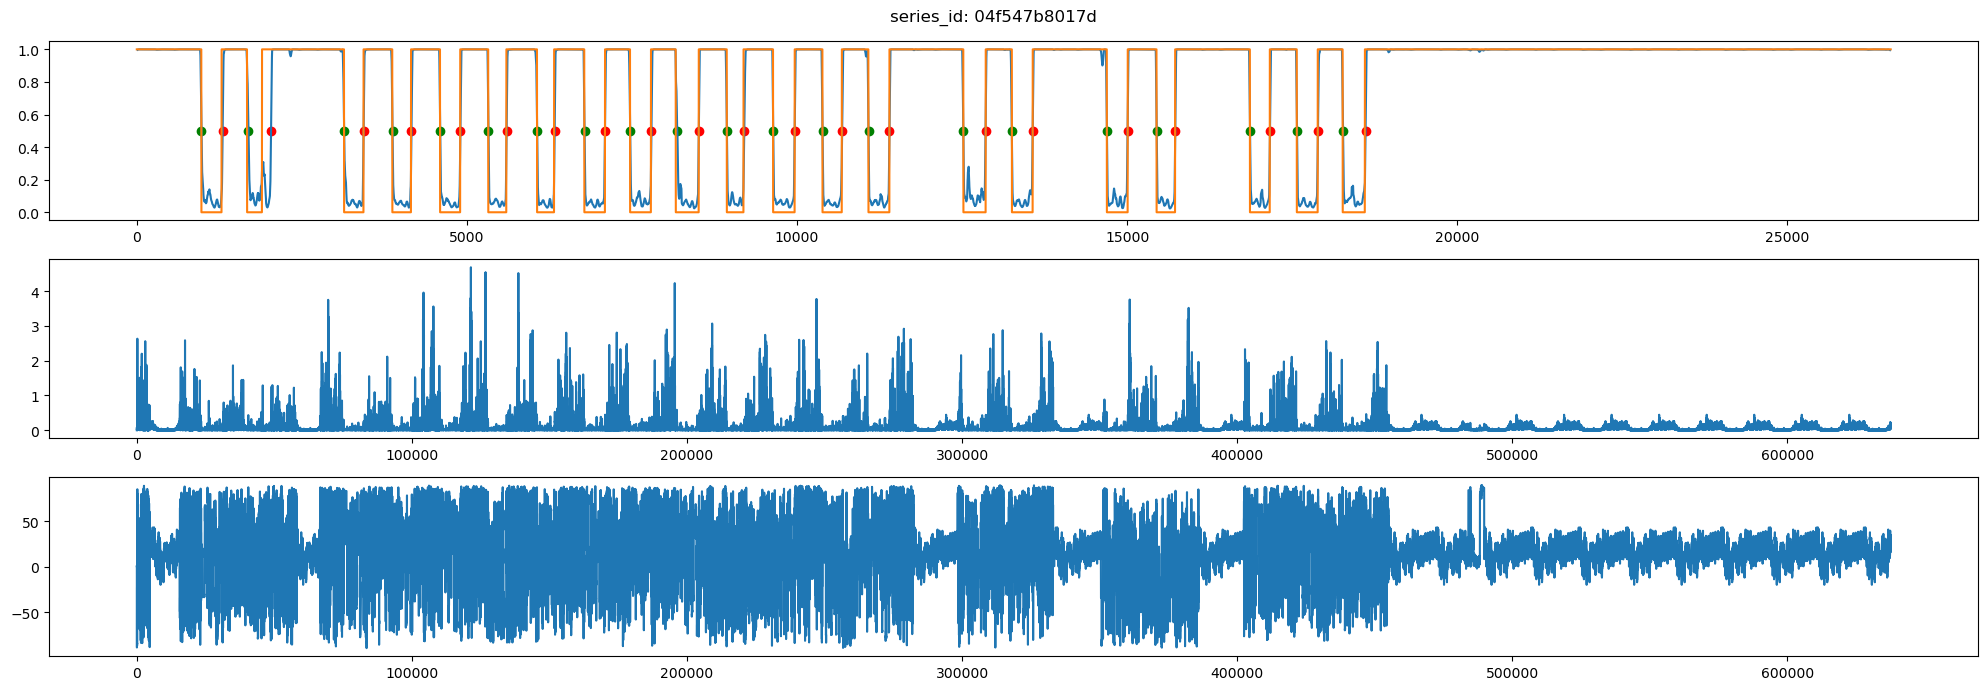

,series_id,step,event,score
0,038441c925bb,10919,wakeup,1
1,038441c925bb,23639,wakeup,1
2,038441c925bb,27383,wakeup,1
3,038441c925bb,44183,wakeup,1
4,038441c925bb,61127,wakeup,1


In [8]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(24, center=True).mean()
    wakeup_index = np.array([i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(oof)
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.3772


event   tolerance
onset   12           0.002955
        36           0.030011
        60           0.094464
        90           0.202603
        120          0.355309
        150          0.445629
        180          0.518177
        240          0.582907
        300          0.625298
        360          0.650535
wakeup  12           0.007847
        36           0.070724
        60           0.181311
        90           0.324327
        120          0.424450
        150          0.501419
        180          0.551347
        240          0.625465
        300          0.660755
        360          0.688872
dtype: float64

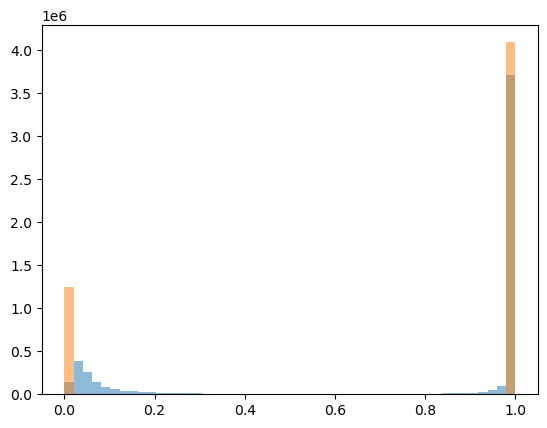

In [9]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [10]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    next_cand = np.zeros(int(train_df["step"].max()) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9569
next_cand_size: 16676784.0
